Продолжаем предобрабатывать данные

- В этом уроке познакомимся с [merge и join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) в Pandas
- А также рассмотрим продвинутый прием по работе с данными при помощи метода [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

In [3]:
import pandas as pd
import numpy as np

In [33]:
submissions_data = pd.read_csv('stepik_data/submissions_data_train.csv')

In [34]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [52]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [36]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [37]:
users_scores = submissions_data.pivot_table(index='user_id', 
                                            columns='submission_status', 
                                            values='step_id',
                                            aggfunc='count', 
                                            fill_value=0).reset_index()

In [38]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [10]:
events_data = pd.read_csv('stepik_data/event_data_train.csv')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [15]:
# убираем дубликаты у юзер_ид и дни, а оставляем уникальное значение для таймстэмп
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230
...,...,...,...
3480298,364,2018-05-19,1526762223
3480329,22851,2018-05-19,1526762629
3480333,943,2018-05-19,1526762664
3480669,26659,2018-05-19,1526770439


In [14]:
# группируем по юзер_ид, а таймстэмп превращаем в лист 
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [20]:
# подсчитываем уникальные значение. узнаем сколько уникальных дней пользовался заходил на степик
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [16]:
np.diff([1, 3, 5])

array([2, 2])

In [21]:
# из списка списков превращаем в один список; axis=0 - для строк

gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [24]:
# получаем дни, разница между заходями в днях 
gap_data = gap_data / (24 * 60 * 60)

<AxesSubplot:>

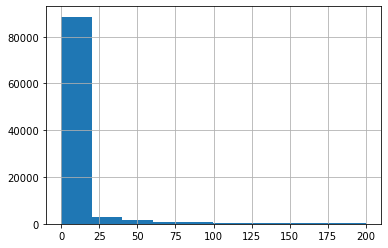

In [25]:
gap_data[gap_data < 200].hist() 

In [26]:
# только 5% пользователей возращаются на курс через 59 дней:
gap_data.quantile(0.95)

59.760440972222156

# Задача найти Анталия в user_id

In [6]:
events_data = pd.read_csv('stepik_data/event_data_train.csv')
ak = events_data[['user_id', 'action']]
ak.head()

,user_id,action
0,17632,viewed
1,17632,passed
2,17632,discovered
3,17632,discovered
4,17632,viewed


In [12]:
# Ответ 1046
ak.groupby('user_id').count().sort_values('action')

,action
user_id,
26502,1
8773,1
11437,1
16682,2
16697,2
...,...
3572,7905
1046,9095
25279,10179


In [14]:
events_data = pd.read_csv('stepik_data/event_data_train.csv')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.groupby('user_id')['day'].nunique().idxmax()

1046

In [17]:
new_df = submissions_data.pivot_table(index='user_id', 
                                      columns='submission_status', 
                                      values='step_id', 
                                      aggfunc='count')

new_df[new_df['correct'] == new_df['correct'].max()]

submission_status,correct,wrong
user_id,,
1046,421.0,513.0


In [16]:
#Первый прошедший последний стэп:
events_data[(events_data.action == 'passed') & (events_data.step_id == events_data.step_id.max())]

,step_id,timestamp,action,user_id,date,day
1780990,158433,1485263664,passed,1046,2017-01-24 13:14:24,2017-01-24
1781275,158433,1485271669,passed,3931,2017-01-24 15:27:49,2017-01-24
1781402,158433,1485276014,passed,14985,2017-01-24 16:40:14,2017-01-24
1782093,158433,1485288441,passed,10626,2017-01-24 20:07:21,2017-01-24
1782261,158433,1485292242,passed,3876,2017-01-24 21:10:42,2017-01-24
...,...,...,...,...,...,...
3478762,158433,1526744472,passed,19147,2018-05-19 15:41:12,2018-05-19
3479191,158433,1526750524,passed,13751,2018-05-19 17:22:04,2018-05-19
3479506,158433,1526754540,passed,19491,2018-05-19 18:29:00,2018-05-19
3479620,158433,1526755659,passed,2058,2018-05-19 18:47:39,2018-05-19


Будем считать что человек бросил курс если не получил сертификат и не заходил на курс в течение 30 дней

In [19]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [20]:
events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).head()

,user_id,timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [21]:
# число обозначающая тридцать дней 
30 * 24 * 60 * 60

2592000

In [24]:
user_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

user_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [28]:
now = 1521634660 # последнние текущие значение
drop_out_threshold = 2592000 # 30 дней в секундах 

In [29]:
# True если пользователm не заходили 30 дней
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_out_threshold

In [30]:
user_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,False
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,False


In [39]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [40]:
# ошибочное слияние inner
user_data.merge(users_scores).head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,2,1519226966,False,2,0
1,3,1444581588,True,29,23
2,5,1499859939,True,2,2
3,8,1481466913,True,9,21
4,14,1436368676,True,0,1


In [42]:
# автоматом ищет по какому значению сделать слияние но можно самому указать 
user_data.merge(users_scores, on='user_id', how='outer').head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,False,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,False,NaN,NaN


In [43]:
user_data = user_data.merge(users_scores, on='user_id', how='outer')

In [44]:
# заполним Na нулями
user_data = user_data.fillna(0)

In [45]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,False,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,False,0.0,0.0


In [46]:
users_events_data = events_data.pivot_table(index='user_id', 
                                            columns='action', 
                                            values='step_id',
                                            aggfunc='count', 
                                            fill_value=0)

In [47]:
users_events_data.head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


In [49]:
user_data = user_data.merge(users_events_data, on='user_id', how='outer')

In [50]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,False,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,False,0.0,0.0,1,1,0,1


In [54]:
users_days = events_data.groupby('user_id').day.nunique()

In [55]:
users_days.to_frame()

,day
user_id,
1,1
2,2
3,7
5,2
7,1
...,...
26790,4
26793,1
26794,9


In [57]:
user_data = user_data.merge(users_days, on='user_id', how='outer')

In [58]:
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,False,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,False,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [59]:
# проверим не потеряли ли мы данные
user_data.user_id.nunique()

19234

In [60]:
events_data.user_id.nunique()

19234

In [61]:
user_data['passed_course'] = user_data.passed > 170 

In [ ]:
# или 
user_data['passed_corse'].value_counts(normalize=True) # доля прошедших курс

In [62]:
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,False,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,False,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [63]:
user_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [64]:
# сколько прошли в %
100 * 1425 / 19234 

7.408755329104711

In [65]:
# не прошли 
100 * 17809 / 19234

92.59124467089529

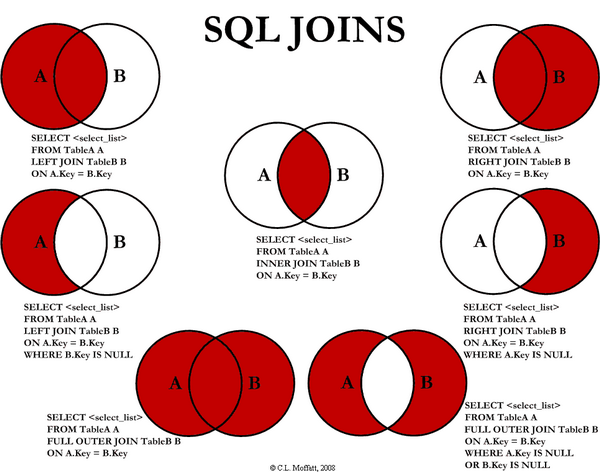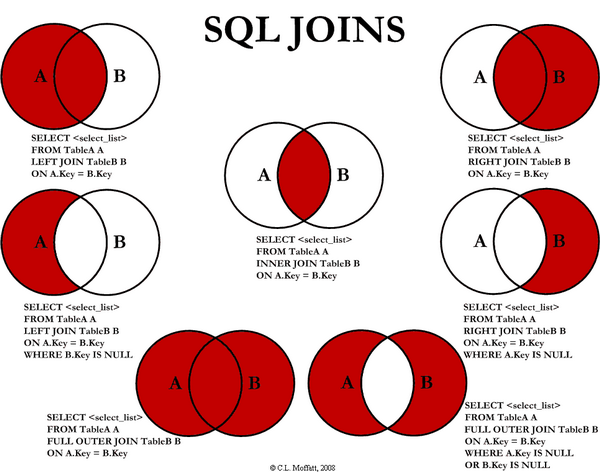

- [eng](https://dzone.com/articles/say-no-to-venn-diagrams-when-explaining-joins)
- [ru](https://habr.com/ru/post/448072/)